<a href="https://colab.research.google.com/github/ymiftah/machine_learning/blob/master/digits_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digits MNIST

This notebook retrace various experiments with the MNIST dataset. A final estimator was built for a Kaggle submission

In [0]:
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

We fetch the data from openml database

In [20]:
mnist = fetch_openml('mnist_784')
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8)
print(y.shape)

(70000,)


Looking at a histogram for each class, we see that they are not evenly distributed, but the difference should be minor

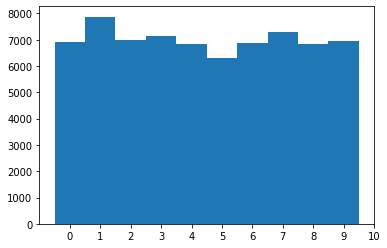

In [21]:
bins = np.arange(0, 9 + 1.5) - 0.5
# then you plot away
fig, ax = plt.subplots()
_ = ax.hist(y, bins)
ax.set_xticks(bins+0.5)
plt.show()

Lets look at one of the digit and its label

This is a 4


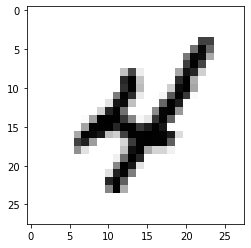

In [22]:
digit = X[9]
digit_im = digit.reshape(28, 28)
plt.imshow(digit_im, interpolation='nearest', cmap=mpl.cm.binary)
print('This is a %d' %int(y[9]))

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

We start by scaling our data between 0 and 1

In [0]:
X_train /= 255
X_test /= 255

We also prepare the Image data generator for the Deep Neural Network trained later

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# applying transformation to image
train_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               shear_range=0.3, 
                               height_shift_range=0.08, 
                               zoom_range=0.08 )
training_set = train_gen.flow(X_train.reshape((X_train.shape[0], 28, 28, 1)), y_train, batch_size=128)
test_set= train_gen.flow(X_test.reshape((X_test.shape[0], 28, 28, 1)), y_test, batch_size=128)

In [26]:
def forest_training(iterations, generator):
    X = []
    Y = []
    for _ in range(iterations):
        x, y = generator.next()
        x = x.reshape((x.shape[0], 28*28*1))
        X.append(x)
        Y.append(y)
    X = np.concatenate(X)
    Y = np.concatenate(Y)
    return X, Y

Xf, Yf = forest_training(1500, training_set)
print(Yf.shape)

(191928,)


## Neural Network

In this section we will fit a neural network.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

def create_model():
    # Define Model
    model = models.Sequential()
    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    # Compile Model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [0]:
model = create_model()

In [29]:
model.fit_generator(training_set, 
                     steps_per_epoch=60000//128, 
                     validation_data= test_set, 
                     validation_steps=10000//128, 
                     epochs=20)

Epoch 1/20
468/468 [==============================] - 33s 70ms/step - loss: 0.4114 - acc: 0.8694 - val_loss: 0.1558 - val_acc: 0.9512
Epoch 2/20
468/468 [==============================] - 31s 67ms/step - loss: 0.1272 - acc: 0.9611 - val_loss: 0.0961 - val_acc: 0.9697
Epoch 3/20
468/468 [==============================] - 32s 68ms/step - loss: 0.0950 - acc: 0.9709 - val_loss: 0.0739 - val_acc: 0.9757
Epoch 4/20
468/468 [==============================] - 31s 67ms/step - loss: 0.0758 - acc: 0.9763 - val_loss: 0.0697 - val_acc: 0.9779
Epoch 5/20
468/468 [==============================] - 31s 67ms/step - loss: 0.0630 - acc: 0.9800 - val_loss: 0.0687 - val_acc: 0.9781
Epoch 6/20
468/468 [==============================] - 31s 67ms/step - loss: 0.0579 - acc: 0.9816 - val_loss: 0.0589 - val_acc: 0.9833
Epoch 7/20
468/468 [==============================] - 32s 68ms/step - loss: 0.0537 - acc: 0.9827 - val_loss: 0.0452 - val_acc: 0.9848
Epoch 8/20
468/468 [==============================] - 32s 68ms

In [30]:
test_loss, test_acc = model.evaluate(X_test.reshape((X_test.shape[0], 28, 28, 1)), y_test)

21000/21000 [==============================] - 3s 135us/sample - loss: 0.0274 - acc: 0.9921


In [31]:
print(test_acc)

0.99209523


## Random Forest classifier

In this section we will implement a random forest classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=256, max_depth=32,
                             random_state=0)

In [33]:
forest_clf.fit(Xf, Yf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=32, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=256,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [34]:
forest_clf.score(X_train, y_train) 

0.9646938775510204

In [35]:
forest_clf.score(X_test, y_test) 

0.9614285714285714

## Voting Classifier

In [37]:
ann_pred = model.predict_proba(X_test.reshape((X_test.shape[0], 28, 28, 1)))
rf_pred = forest_clf.predict_proba(X_test)
joint_proba = np.sqrt(ann_pred**2 + rf_pred**2)

joint_pred = np.argmax(joint_proba, axis=1)
joint_poba = np.max(joint_proba, axis=1)

from sklearn import metrics

expected = y_test
predicted = joint_pred
print("Classification report for classifier %s:\n%s\n"
      % ('Joint', metrics.classification_report(expected, predicted, digits=4)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier Joint:
              precision    recall  f1-score   support

           0     0.9980    0.9922    0.9951      2058
           1     0.9966    0.9949    0.9958      2364
           2     0.9967    0.9930    0.9948      2133
           3     0.9927    0.9968    0.9947      2176
           4     0.9943    0.9861    0.9901      1936
           5     0.9896    0.9943    0.9919      1915
           6     0.9986    0.9904    0.9945      2088
           7     0.9911    0.9947    0.9929      2248
           8     0.9836    0.9930    0.9883      1992
           9     0.9848    0.9904    0.9876      2090

    accuracy                         0.9927     21000
   macro avg     0.9926    0.9926    0.9926     21000
weighted avg     0.9927    0.9927    0.9927     21000


Confusion matrix:
[[2042    0    0    1    1    2    3    0    9    0]
 [   0 2352    1    0    1    1    0    7    1    1]
 [   1    2 2118    5    0    0    0    5    2    0]
 [   0    0    0 21

In [38]:
fail = expected != predicted
fail_exp = expected[fail]
fail_pred = predicted[fail]
X_fail = X_test[fail,:]
proba_fail = joint_poba[fail]
X_fail.shape

(154, 784)

In [39]:
len(proba_fail[proba_fail > 0.95])

54

This is a 9
The model predicted 8
with certainty 0.960344


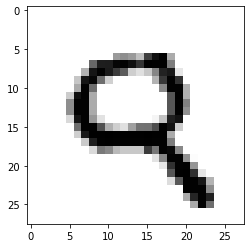

In [40]:
num = 17

digit = X_fail[num]
digit_im = digit.reshape(28, 28)
plt.imshow(digit_im, interpolation='nearest', cmap=mpl.cm.binary)
print('This is a %d' %int(fail_exp[num]))
print('The model predicted %d' %(int(fail_pred[num])))
print('with certainty %f' %(proba_fail[num]))

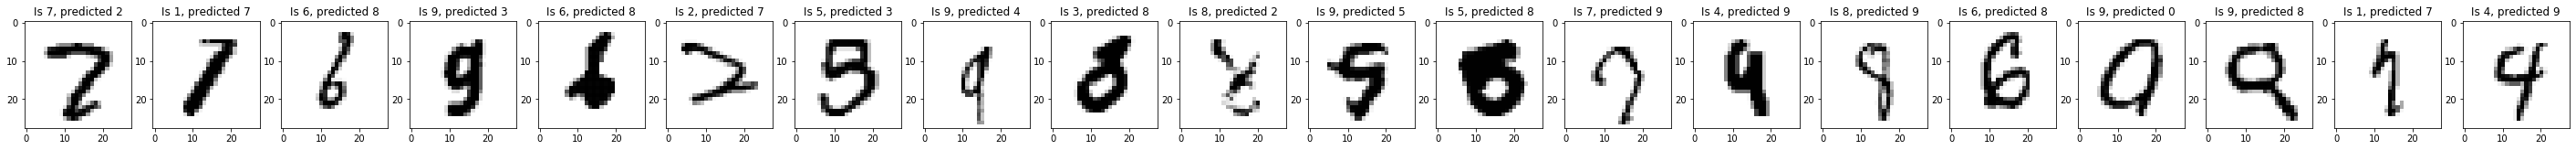

In [52]:
fig, axs = plt.subplots(1, 20, figsize=(50, 5))

for c, ax in enumerate(axs):
    digit = X_fail[c]
    digit = digit.reshape(28, 28)
    ax.imshow(digit, interpolation='nearest', cmap=mpl.cm.binary)
    ax.set_title('Is %d, predicted %d' %(int(fail_exp[c]), int(fail_pred[c])))

plt.show()

As we can see above some of the mismatches are actually difficult to ascertain even for a human.
The model is achieving pretty good !